In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the dataset

##### This dataset contains some texts and they are labelled with some emotions: 
##### Sadness, Joy, Love, Anger, Fear, Surprise

##### In this dataset, they are already label encoded. This dictionary signifies which label refers to which emotion

In [2]:
emolabels = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
df = pd.read_csv('/content/drive/MyDrive/emotions_training/Emotions_training.csv')
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


##### Let's Explore the dataset

In [3]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


##### Distribution of classified data

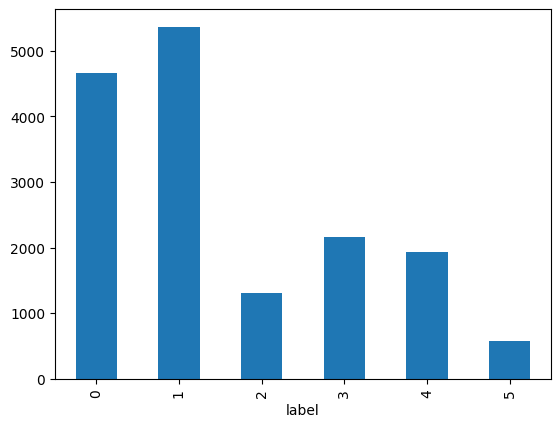

In [4]:
sent_count = df.groupby('label').size()
sent_count.plot(kind='bar')
plt.show()

##### We can clearly see that, this dataset has imbalanced number of classes.

##### Now, Let's perform the preprocessing first before diving into the modelling part.

In [5]:
## Preprocessing Pipeline

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class LowercasingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.lower()

class RemoveHyperlinksTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        pattern = r'\bhttps?://\S+\b|\bwww\.\S+\b'
        return X.str.replace(pattern, '', regex=True)

class RemoveNewlineTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.replace('\n', '')

class RemoveExtraSpacesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.replace(r'\s+', ' ', regex=True)

class RemoveSpecialCharactersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

nlp_pipeline = Pipeline([
    ('lowercasing', LowercasingTransformer()),
    ('remove_hyperlinks', RemoveHyperlinksTransformer()),
    ('remove_newlines', RemoveNewlineTransformer()),
    ('remove_extra_spaces', RemoveExtraSpacesTransformer()),
    ('remove_special_characters', RemoveSpecialCharactersTransformer())
])

##### Fitting the model into the preprocessing pipeline

In [6]:
X = nlp_pipeline.fit_transform(df['text'])
y = df['label']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12800,)
(3200,)
(12800,)
(3200,)


### Modelling

#### Importing necessary packages

In [7]:
import tensorflow as tf
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

#### Tokenizing the data

In [8]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

##### Getting the Vocabulary Length

In [10]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

13455

##### Maximum sentence length

In [11]:
sent_lens = [len(i) for i in X]
max(sent_lens)

300

##### Padding all the sentences

In [12]:
maxlen = max(sent_lens)

from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='pre', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='pre', maxlen=maxlen)

### Designing the LSTM based Neural Network

In [25]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(vocab_length,embedding_vector_features,input_length=maxlen))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 40)           538200    
                                                                 
 dropout_2 (Dropout)         (None, 300, 40)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 595206 (2.27 MB)
Trainable params: 595206 (2.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


##### Fitting the model, training over 10 epochs

In [26]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
200/200 [==============================] - 30s 138ms/step - loss: 1.5491 - accuracy: 0.3741 - val_loss: 1.3841 - val_accuracy: 0.4859
Epoch 2/10
200/200 [==============================] - 9s 46ms/step - loss: 0.9331 - accuracy: 0.6700 - val_loss: 0.7221 - val_accuracy: 0.7569
Epoch 3/10
200/200 [==============================] - 4s 21ms/step - loss: 0.4582 - accuracy: 0.8555 - val_loss: 0.4268 - val_accuracy: 0.8628
Epoch 4/10
200/200 [==============================] - 4s 21ms/step - loss: 0.2420 - accuracy: 0.9262 - val_loss: 0.3666 - val_accuracy: 0.8834
Epoch 5/10
200/200 [==============================] - 6s 29ms/step - loss: 0.1613 - accuracy: 0.9495 - val_loss: 0.3365 - val_accuracy: 0.8947
Epoch 6/10
200/200 [==============================] - 4s 21ms/step - loss: 0.1245 - accuracy: 0.9616 - val_loss: 0.3088 - val_accuracy: 0.9009
Epoch 7/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0983 - accuracy: 0.9707 - val_loss: 0.3323 - val_accuracy: 0.89

##### Checking the predictions

In [27]:
y_pred_classes = np.argmax(model.predict(X_test), axis=1)

100/100 [==============================] - 1s 6ms/step


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

0.8953125
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       905
           1       0.90      0.94      0.92      1053
           2       0.80      0.80      0.80       271
           3       0.90      0.83      0.87       459
           4       0.86      0.88      0.87       397
           5       0.76      0.80      0.78       115

    accuracy                           0.90      3200
   macro avg       0.86      0.86      0.86      3200
weighted avg       0.90      0.90      0.90      3200



Text(50.722222222222214, 0.5, 'True Labels')

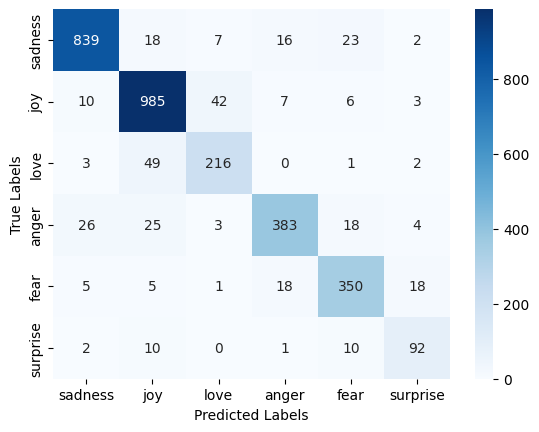

In [28]:
print(accuracy_score(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))
conf_matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="g", xticklabels=emolabels.values(), yticklabels=emolabels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [29]:
model.save('/content/drive/MyDrive/emotions_training/lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### The model are created in this project is saved in the same folder. This is a natural language dataset that is preprocessed and used to train the LSTM Model.

##### This dataset has imbalanced set of classes. Without any upsampling, downsampling or synthetic data generaton, this LSTM model is created.

##### LSTM or "Long Short-Term Memory" is effective for working with Natural Language Processing. Here we can see, this approach works better than traditional Machine Learning models.